In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

# Use the following lines to test the basic functionality of the package if developing locally: 
import sys, os
sys.path.insert(0, "../src/")
from graph import *

This notebook showcases the first few steps of the Omics Integrator network analysis pipeline: 
1. Parameter selection
2. Randomization experiments

In order to use the visualizations, please follow the setup instructions [here](https://www.datacamp.com/community/blog/jupyter-notebook-r).

In [2]:
def summarize_grid_search(graph, results, mode="robustness"): 
    
    # Exclude any degenerate results
    results = [x for x in results if len(get_networkx_graph_as_dataframe_of_nodes(x[2]))>0]
    
    if mode == "membership": # Summarize single-run parameter search
        df = pd.concat([(get_networkx_graph_as_dataframe_of_nodes(augmented_forest)["degree"]>0).astype(int) for _,_,augmented_forest in results if len(augmented_forest)>0], axis=1).fillna(0)
    elif mode == "robustness": # Summarize randomized robustness
        df = pd.concat([get_networkx_graph_as_dataframe_of_nodes(augmented_forest)["robustness"] for _,_,augmented_forest in results], axis=1).fillna(0)
    elif mode == "specificity": # Summarize randomized specificity
        df = pd.concat([get_networkx_graph_as_dataframe_of_nodes(augmented_forest)["specificity"] for _,_,augmented_forest in results], axis=1).fillna(0)
    else:
        print("Must specificy a correct mode: 'membership', 'robustness', or 'specificity'.")
        return
        
    df.columns = [param_string for param_string,_,_ in results]
    
    # Fetch node attributes
    degrees = pd.DataFrame.from_dict({node: len(graph.interactome_graph[node]) for node in df.index}, orient="index")
    degrees["log_degree"] = np.log2(degrees[0])

    prizes_dataframe = pd.read_csv(prize_file, sep='\t').set_index("name")

    df = pd.concat([df, degrees["log_degree"]], axis=1).merge(prizes_dataframe, left_index=True, right_index=True, how="left")
    df["type"] = df["type"].fillna(value="steiner")
    df.fillna(0, inplace=True)
    
    return df

In [3]:
%load_ext rpy2.ipython
%R require(ggplot2); require(tidyr)

array([1], dtype=int32)

In [4]:
%%R 

library(ComplexHeatmap)
library(circlize)
library(colorspace)
library(GetoptLong)

plotHeatmap <- function(nodes) {
    mat <- t(nodes[, grep("G_", colnames(nodes))])

    names <- colnames(nodes)[grep("G_", colnames(nodes))]
    tmp <- data.frame(do.call(rbind, strsplit(names, '_', fixed=TRUE)))[,c(2,4,6)]
    colnames(tmp) <- c("g", "b", "w")
    indx <- sapply(tmp, is.factor)
    tmp[indx] <- lapply(tmp[indx], function(x) as.numeric(as.character(x)))
    tmp$g <- log10(tmp$g)

    annotation_df = nodes[,c("type", "log_degree", "prizes")]
    ha = HeatmapAnnotation(df=annotation_df, col=list(prizes = colorRamp2(c(0,max(nodes$prize)), c("white", "orange")), 
                                                      log_degree=colorRamp2(c(0,5,max(nodes$log_degree)), c("blue", "white", "red")), 
                                                      type=c("steiner"="blue", "terminal"="red", "TF"="green")), 
                           annotation_legend_param=list(prizes=list(legend_direction="horizontal"),
                                                        log_degree=list(legend_direction="horizontal"),
                                                        type=list(legend_direction="horizontal")))

    ht = Heatmap(mat, name="Node Membership", col=c("white", "black"), show_row_names=F, top_annotation=ha, top_annotation_height = unit(12, "mm")) +
        Heatmap(tmp$w, name="W", col=colorRamp2(c(0, max(tmp$w)), c("white", "red")), width=unit(6, "mm")) +
        Heatmap(tmp$b, name="B", col=colorRamp2(c(0, max(tmp$b)), c("white", "blue")), width=unit(6, "mm")) +
        Heatmap(tmp$g, name="G", col=colorRamp2(c(0, max(tmp$g)), c("white", "green")), width=unit(6, "mm"))

    draw(ht, heatmap_legend_side = "right", annotation_legend_side = "top")
}

# 1. Parameter sweep

In [5]:
interactome_file = "../../../data/interactome/iRefIndex_v14_MIScore_interactome_C9.costs.txt"
prize_file = "../../fly_networks_20180416/prizes.txt"
output_dir = "."

graph = Graph(interactome_file, {})
graph.prepare_prizes(prize_file)

05:31:05 - Graph: INFO - Duplicated edges in the interactome file (we'll keep the max cost):
05:31:05 - Graph: INFO - []
05:31:07 - Graph: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:07 - Graph: INFO - ['HNRNPA2B1']
05:31:07 - Graph: INFO - Members of the prize file not present in the interactome:
05:31:07 - Graph: INFO - []


In [6]:
params = {
    "w": [0.25, 0.5, 0.75, 1], 
    "b": [0.25, 0.5, 0.75, 1, 1.5, 2], 
    "g": [1000, 3000, 10000, 30000], 
    "noise": 0.1, 
    "dummy_mode": "terminals", 
    "exclude_terminals": False, 
    "seed": 1,
    "noisy_edges_repetitions": 0, 
    "random_terminals_repetitions": 0
}

params = {param: value for param, value in params.items() if value is not None}
params

{'w': [0.25, 0.5, 0.75, 1],
 'b': [0.25, 0.5, 0.75, 1, 1.5, 2],
 'g': [1000, 3000, 10000, 30000],
 'noise': 0.1,
 'dummy_mode': 'terminals',
 'exclude_terminals': False,
 'seed': 1,
 'noisy_edges_repetitions': 0,
 'random_terminals_repetitions': 0}

In [7]:
results = graph._grid_randomization(prize_file, params)

05:31:07 - Graph: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:07 - Graph: INFO - ['HNRNPA2B1']
05:31:07 - Graph: INFO - Members of the prize file not present in the interactome:
05:31:07 - Graph: INFO - []
05:31:09 - Graph: INFO - Randomizations for G_1000_B_0.25_W_0.25
05:31:09 - Graph: INFO - {'w': 0.25, 'b': 0.25, 'g': 1000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 0, 'random_terminals_repetitions': 0}
05:31:09 - Graph: INFO - Randomizations for G_30000_B_0.25_W_0.25
05:31:09 - Graph: INFO - {'w': 0.25, 'b': 0.25, 'g': 30000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 0, 'random_terminals_repetitions': 0}
05:31:10 - Graph: INFO - Randomizations for G_10000_B_0.5_W_0.25
05:31:10 - Graph: INFO - {'w': 0.25, 'b': 0.5, 'g': 10000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edge

05:31:19 - Graph: INFO - Randomizations for G_1000_B_0.5_W_0.5
05:31:19 - Graph: INFO - {'w': 0.5, 'b': 0.5, 'g': 1000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 0, 'random_terminals_repetitions': 0}
05:31:19 - Graph: INFO - Randomizations for G_30000_B_1_W_0.5
05:31:19 - Graph: INFO - {'w': 0.5, 'b': 1, 'g': 30000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 0, 'random_terminals_repetitions': 0}
05:31:19 - Graph: INFO - Randomizations for G_30000_B_0.5_W_0.5
05:31:19 - Graph: INFO - {'w': 0.5, 'b': 0.5, 'g': 30000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 0, 'random_terminals_repetitions': 0}
05:31:19 - Graph: INFO - Randomizations for G_10000_B_1.5_W_0.5
05:31:19 - Graph: INFO - {'w': 0.5, 'b': 1.5, 'g': 10000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'no

05:31:27 - Graph: INFO - Randomizations for G_3000_B_2_W_0.75
05:31:27 - Graph: INFO - {'w': 0.75, 'b': 2, 'g': 3000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 0, 'random_terminals_repetitions': 0}
05:31:27 - Graph: INFO - Not assigning subcellular locations. For that function use Gene Symbols.
05:31:28 - Graph: INFO - Randomizations for G_3000_B_1_W_0.75
05:31:28 - Graph: INFO - {'w': 0.75, 'b': 1, 'g': 3000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 0, 'random_terminals_repetitions': 0}
05:31:28 - Graph: INFO - Randomizations for G_3000_B_0.5_W_0.75
05:31:28 - Graph: INFO - {'w': 0.75, 'b': 0.5, 'g': 3000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 0, 'random_terminals_repetitions': 0}
05:31:28 - Graph: INFO - Randomizations for G_1000_B_1.5_W_0.75
05:31:28 - Graph: INFO - {'w': 0.75, 'b': 1.5

05:31:36 - Graph: INFO - {'w': 1, 'b': 1.5, 'g': 30000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 0, 'random_terminals_repetitions': 0}
05:31:36 - Graph: INFO - Randomizations for G_30000_B_0.75_W_1
05:31:36 - Graph: INFO - {'w': 1, 'b': 0.75, 'g': 30000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 0, 'random_terminals_repetitions': 0}
05:31:36 - Graph: INFO - Randomizations for G_10000_B_2_W_1
05:31:36 - Graph: INFO - {'w': 1, 'b': 2, 'g': 10000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 0, 'random_terminals_repetitions': 0}
05:31:36 - Graph: INFO - Randomizations for G_10000_B_1_W_1
05:31:36 - Graph: INFO - {'w': 1, 'b': 1, 'g': 10000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 0, 'random_terminals_repetitions': 0}
05:31:36 - Graph

In [8]:
membership_df = summarize_grid_search(graph, results, "membership")

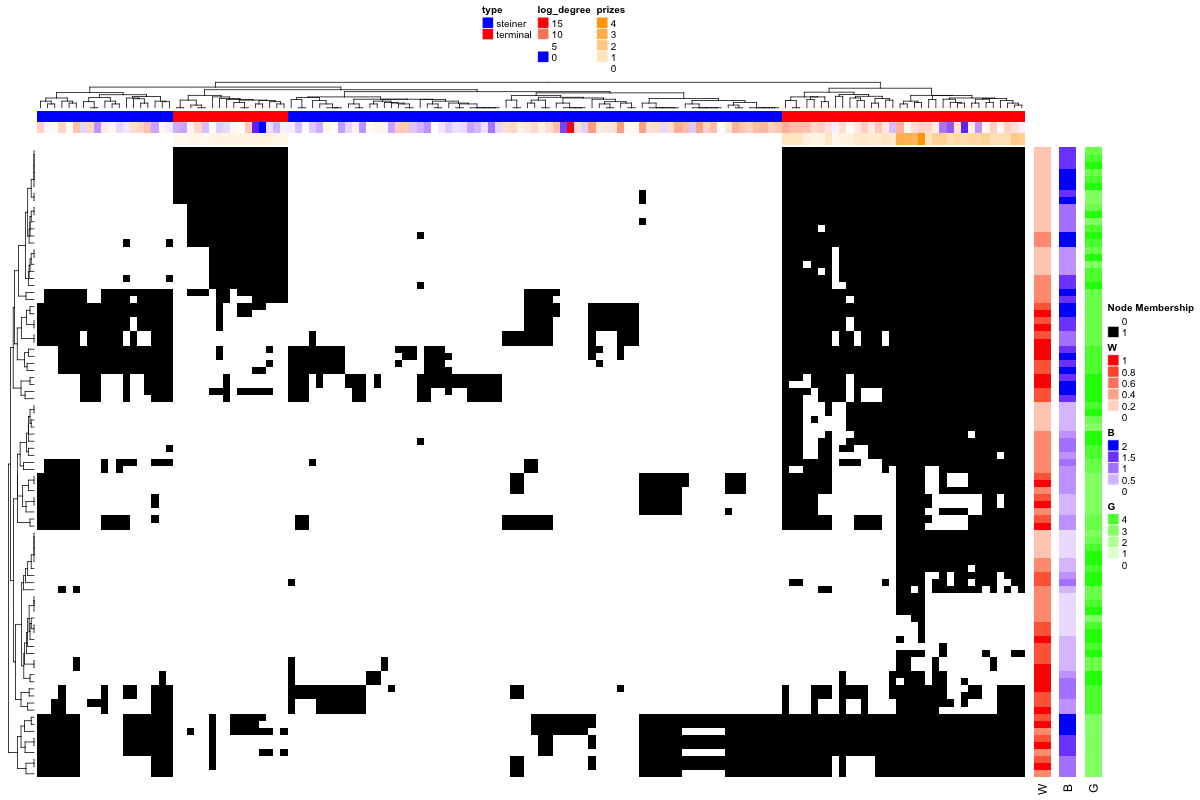

In [9]:
%%R -i membership_df -w 1200 -h 800 -u px

plotHeatmap(membership_df)

# 2. Randomization

In [10]:
interactome_file = "../../../data/interactome/iRefIndex_v14_MIScore_interactome_C9.costs.txt"
prize_file = "../../fly_networks_20180416/prizes.txt"
output_dir = "."

graph = Graph(interactome_file, {})
graph.prepare_prizes(prize_file)

05:31:47 - Graph: INFO - Duplicated edges in the interactome file (we'll keep the max cost):
05:31:47 - Graph: INFO - []
05:31:49 - Graph: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:49 - Graph: INFO - ['HNRNPA2B1']
05:31:49 - Graph: INFO - Members of the prize file not present in the interactome:
05:31:49 - Graph: INFO - []


In [11]:
params = {
    "w": [0.25, 0.5, 0.75, 1], 
    "b": [0.25, 0.5, 0.75, 1, 1.5, 2], 
    "g": [1000, 3000, 10000, 30000], 
    "noise": 0.1, 
    "dummy_mode": "terminals", 
    "exclude_terminals": False, 
    "seed": 1,
    "noisy_edges_repetitions": 10, 
    "random_terminals_repetitions": 10
}

params = {param: value for param, value in params.items() if value is not None}
params

{'w': [0.25, 0.5, 0.75, 1],
 'b': [0.25, 0.5, 0.75, 1, 1.5, 2],
 'g': [1000, 3000, 10000, 30000],
 'noise': 0.1,
 'dummy_mode': 'terminals',
 'exclude_terminals': False,
 'seed': 1,
 'noisy_edges_repetitions': 10,
 'random_terminals_repetitions': 10}

In [12]:
results = graph._grid_randomization(prize_file, params)

05:31:49 - Graph: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:49 - Graph: INFO - ['HNRNPA2B1']
05:31:49 - Graph: INFO - Members of the prize file not present in the interactome:
05:31:49 - Graph: INFO - []
05:31:50 - Graph: INFO - Randomizations for G_1000_B_0.25_W_0.25
05:31:50 - Graph: INFO - {'w': 0.25, 'b': 0.25, 'g': 1000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 10, 'random_terminals_repetitions': 10}
05:31:51 - Graph: INFO - Randomizations for G_30000_B_0.25_W_0.25
05:31:51 - Graph: INFO - {'w': 0.25, 'b': 0.25, 'g': 30000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 10, 'random_terminals_repetitions': 10}
05:31:51 - Graph: INFO - Randomizations for G_10000_B_0.5_W_0.25
05:31:51 - Graph: INFO - {'w': 0.25, 'b': 0.5, 'g': 10000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_

05:32:21 - Graph: INFO - Randomizations for G_30000_B_1_W_0.5
05:32:21 - Graph: INFO - {'w': 0.5, 'b': 1, 'g': 30000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 10, 'random_terminals_repetitions': 10}
05:32:22 - Graph: INFO - Randomizations for G_1000_B_0.5_W_0.5
05:32:22 - Graph: INFO - Randomizations for G_10000_B_1.5_W_0.5
05:32:22 - Graph: INFO - {'w': 0.5, 'b': 0.5, 'g': 1000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 10, 'random_terminals_repetitions': 10}
05:32:22 - Graph: INFO - {'w': 0.5, 'b': 1.5, 'g': 10000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 10, 'random_terminals_repetitions': 10}
05:32:22 - Graph: INFO - Randomizations for G_3000_B_2_W_0.5
05:32:22 - Graph: INFO - {'w': 0.5, 'b': 2, 'g': 3000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'no

05:33:02 - Graph: INFO - Randomizations for G_3000_B_0.5_W_0.75
05:33:02 - Graph: INFO - {'w': 0.75, 'b': 0.5, 'g': 3000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 10, 'random_terminals_repetitions': 10}
05:33:05 - Graph: INFO - Randomizations for G_3000_B_2_W_0.75
05:33:05 - Graph: INFO - {'w': 0.75, 'b': 2, 'g': 3000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 10, 'random_terminals_repetitions': 10}
05:33:06 - Graph: INFO - Randomizations for G_1000_B_0.25_W_1
05:33:06 - Graph: INFO - {'w': 1, 'b': 0.25, 'g': 1000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 10, 'random_terminals_repetitions': 10}
05:33:08 - Graph: INFO - Randomizations for G_1000_B_1.5_W_0.75
05:33:08 - Graph: INFO - {'w': 0.75, 'b': 1.5, 'g': 1000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1,

05:34:16 - Graph: INFO - Randomizations for G_1000_B_2_W_1
05:34:16 - Graph: INFO - {'w': 1, 'b': 2, 'g': 1000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 10, 'random_terminals_repetitions': 10}
05:34:19 - Graph: INFO - Randomizations for G_10000_B_1_W_1
05:34:19 - Graph: INFO - {'w': 1, 'b': 1, 'g': 10000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 10, 'random_terminals_repetitions': 10}
05:34:21 - Graph: INFO - Randomizations for G_3000_B_1.5_W_1
05:34:21 - Graph: INFO - {'w': 1, 'b': 1.5, 'g': 3000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetitions': 10, 'random_terminals_repetitions': 10}
05:34:27 - Graph: INFO - Randomizations for G_30000_B_2_W_1
05:34:27 - Graph: INFO - {'w': 1, 'b': 2, 'g': 30000, 'noise': 0.1, 'dummy_mode': 'terminals', 'exclude_terminals': False, 'seed': 1, 'noisy_edges_repetition

In [13]:
robustness_df = summarize_grid_search(graph, results, "robustness")
specificity_df = summarize_grid_search(graph, results, "specificity")

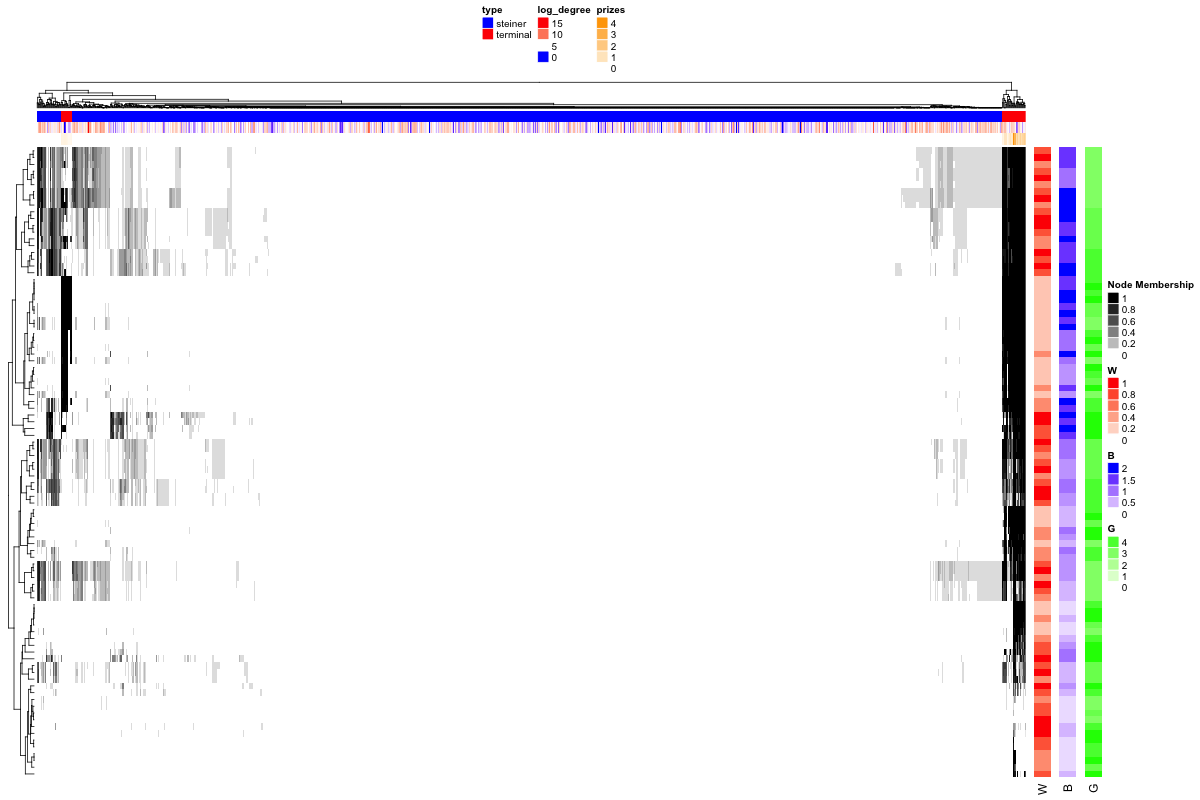

In [14]:
%%R -i robustness_df -w 1200 -h 800 -u px

plotHeatmap(robustness_df)

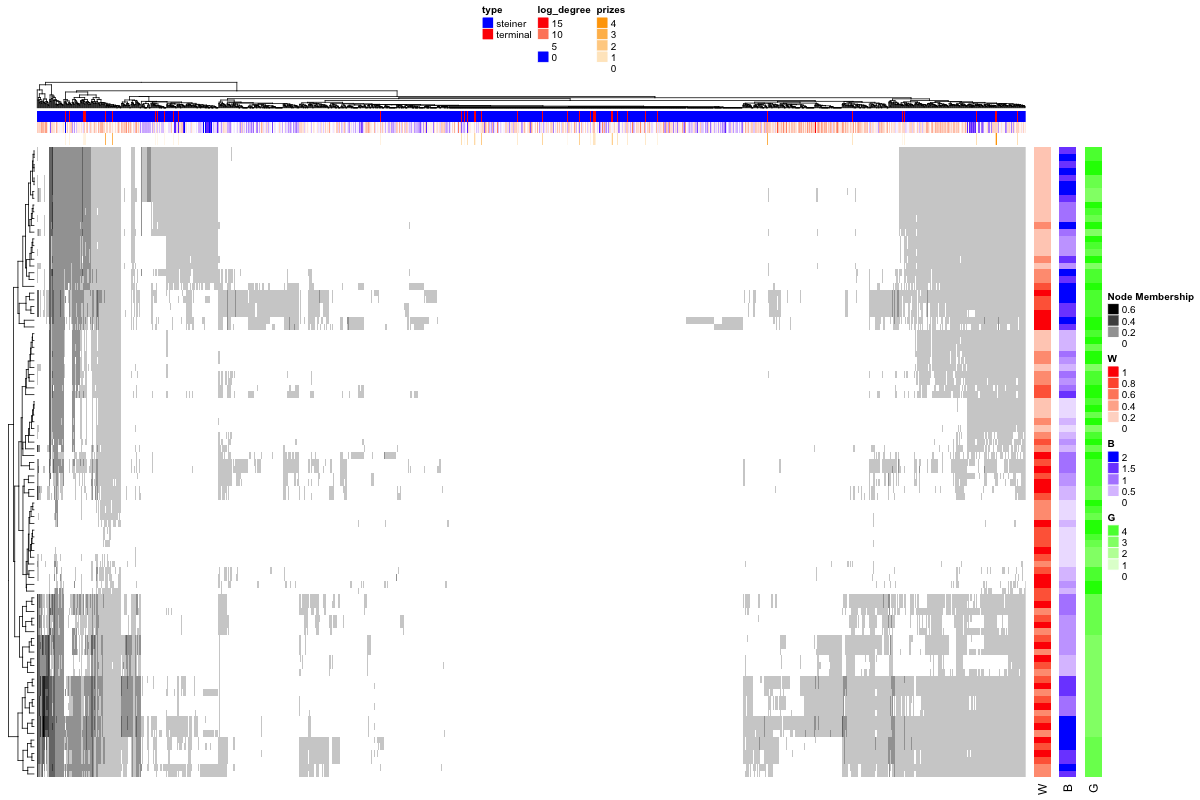

In [15]:
%%R -i specificity_df -w 1200 -h 800 -u px

plotHeatmap(specificity_df)